In [1]:
%matplotlib inline

from badlands import meshtools 
from badlands import TreMesh

import numpy as np


In [2]:
help (meshtools.square_mesh)

Help on function square_mesh in module badlands.tremesh.meshtools:

square_mesh(minX, maxX, minY, maxY, spacingX, spacingY, samples, boundary_samples)



In [3]:
x1, y1, bmask, inverse_bmask = meshtools.square_mesh(-5.0, 5.0, -5.0,  5.0, 0.05, 0.05, 50000, 200 )
z1 = np.exp(-x1**2 -y1**2)

x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)
z5 = np.exp(0.2 * (-x5**2 -y5**2)) + 0.0001 * np.random.rand(len(x5))

mesh1 = TreMesh(x1, y1, bmask, verbose=True)
mesh5 = TreMesh(x5, y5, bmask, verbose=True)

 - Calculating Delaunay Triangulation  0.468811 s
 - Triangulation Neighbour Lists  2.217079 s
 - Triangulation Local Areas and Weights  1.410642 s
 - Triangulation Vector Operators  1.629236 s
 - Local Smoothing Operator  0.282699 s
 - Calculating Delaunay Triangulation  0.427648 s
 - Triangulation Neighbour Lists  2.106017 s
 - Triangulation Local Areas and Weights  1.388846 s
 - Triangulation Vector Operators  1.587282 s
 - Local Smoothing Operator  0.45468 s


In [4]:
print mesh1.assess_derivative_quality()
print mesh5.assess_derivative_quality()

(0.014187505649498789, 0.092920919069906363)
(0.0032075659399904755, 0.024642304664509909)


In [5]:
# %%timeit

gradXz5, gradYz5 = mesh5.delaunay_grad(z5)
gradXz5[inverse_bmask] = 0.0
gradYz5[inverse_bmask] = 0.0
divgradz5 = mesh5.delaunay_div(gradXz5, gradYz5)


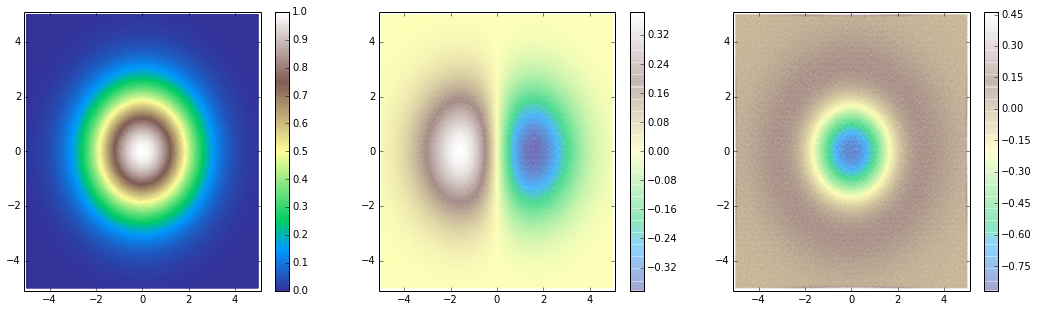

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm


fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(18,5)
fig.set_dpi(300)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)

sm1 = mesh5.add_node_data_to_plot(plot1, z5, cmap=cm.terrain, shading="gouraud")
fig.colorbar(sm1, ax=plot1)

sm2 = mesh5.add_node_data_to_plot(plot2, gradXz5, cmap=cm.terrain, shading="gouraud", alpha=0.25)
fig.colorbar(sm2, ax=plot2)

sm3 = mesh5.add_node_data_to_plot(plot3, divgradz5, cmap=cm.terrain, shading="gouraud", alpha=0.25, linewidth=1)
fig.colorbar(sm3, ax=plot3)
 
# plt.show() 
fig.savefig("TestGradient.png", dpi=600)


In [7]:
%%sh

open TestGradient.png

In [8]:
def delaunay_diffusion_rate(self, kappa, data, fluxBC):
    """
    Compute diffusive rate of change for field 'data' on the delaunay mesh
    
    """

    inverse_bmask = np.invert(self.bmask)
    
    diff_timestep   =  (self.area / kappa).min()

    ## Should wrap this as grad ( A * grad )

    gradZx, gradZy = self.delaunay_grad(data)   
    
    flux_x = kappa * gradZx
    flux_y = kappa * gradZy    
    
    if fluxBC:
        flux_x[inverse_bmask] = 0.0
        flux_y[inverse_bmask] = 0.0  # outward normal flux, actually 
        
    diffDz  = self.delaunay_div(flux_x, flux_y)

    if not fluxBC:
        diffDz[inverse_bmask] = 0.0

    return diffDz, diff_timestep


In [9]:
# Test the time evolution with a mid-point method

import time as systime



# Reset the height

reset = False

if reset:
    z5 = np.exp(-0.025*(x5**4 + y5**4)**1) + 0.0001 * np.random.rand(len(x5))

z0 = z5.copy()

time = 0.0
viz_time= 0.0
vizzes = 0

kappa = np.ones_like(z5) 

for step in range(0,500):
    walltime = systime.clock()
    
    delta = z5-z0
      
    # Diffusion
    
    # kappa[ x5 > 0.0 ] *= 50
    kappa = z5**4  
        
    diffDz, diff_timestep =  delaunay_diffusion_rate(mesh5, kappa, z5, True)

    # Height predictor step (at half time)   
    z5 += 0.5 * diff_timestep *  diffDz

    # Recalculate based on mid-point values
        
    diffDz, diff_timestep =  delaunay_diffusion_rate(mesh5, kappa, z5, True)
     
    # Now take the full timestep

    z5 += diff_timestep *  diffDz
    
    time = time + diff_timestep
    viz_time = viz_time + diff_timestep

  
    if step%100 == 0:
        print "{:04d} - ".format(step), \
          " dt - {:.5f} ".format(diff_timestep), \
          " time - {:.4f}".format(time), \
          " Step walltime - {:.3f}".format(systime.clock()-walltime)
              
    # Store data
    
    if( viz_time > 0.1 or step==0):

        viz_time = 0.0
        vizzes = vizzes + 1

        delta = z5-z0
        np.savez("TEST1.{:04d}".format(vizzes), x=mesh5.x, y=mesh5.y, h=z5, 
                  triang=mesh5.tri.simplices, delta=delta )

 

0000 -   dt - 0.00090   time - 0.0009  Step walltime - 0.013
0100 -   dt - 0.00124   time - 0.1087  Step walltime - 0.011
0200 -   dt - 0.00154   time - 0.2479  Step walltime - 0.008
0300 -   dt - 0.00182   time - 0.4158  Step walltime - 0.009
0400 -   dt - 0.00211   time - 0.6124  Step walltime - 0.008


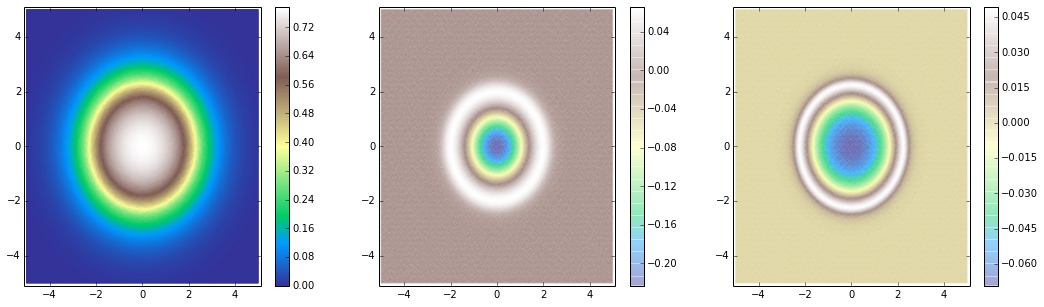

In [10]:
fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(18,5)
fig.set_dpi(300)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)

sm1 = mesh5.add_node_data_to_plot(plot1, z5, cmap=cm.terrain, shading="gouraud")
fig.colorbar(sm1, ax=plot1)

sm2 = mesh5.add_node_data_to_plot(plot2, z5-z0, cmap=cm.terrain, shading="gouraud", alpha=0.25)
fig.colorbar(sm2, ax=plot2)

sm3 = mesh5.add_node_data_to_plot(plot3, diffDz, cmap=cm.terrain, shading="gouraud", alpha=0.25, linewidth=1)
fig.colorbar(sm3, ax=plot3)
 
# plt.show() 
fig.savefig("TestGradient.png", dpi=300)